In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
import random
import pickle
import pandas as pd

In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "the no. of images != no. of labels"
assert(X_valid.shape[0] == y_valid.shape[0]), "the no. of images != no. of labels"
assert(X_test.shape[0] == y_test.shape[0]), "the no. of images != no. of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "the dimensions of the images are not 32x32x3"
assert(X_valid.shape[1:] == (32, 32, 3)), "the dimensions of the images are not 32x32x3"
assert(X_test.shape[1:] == (32, 32, 3)), "the dimensions of the images are not 32x32x3"

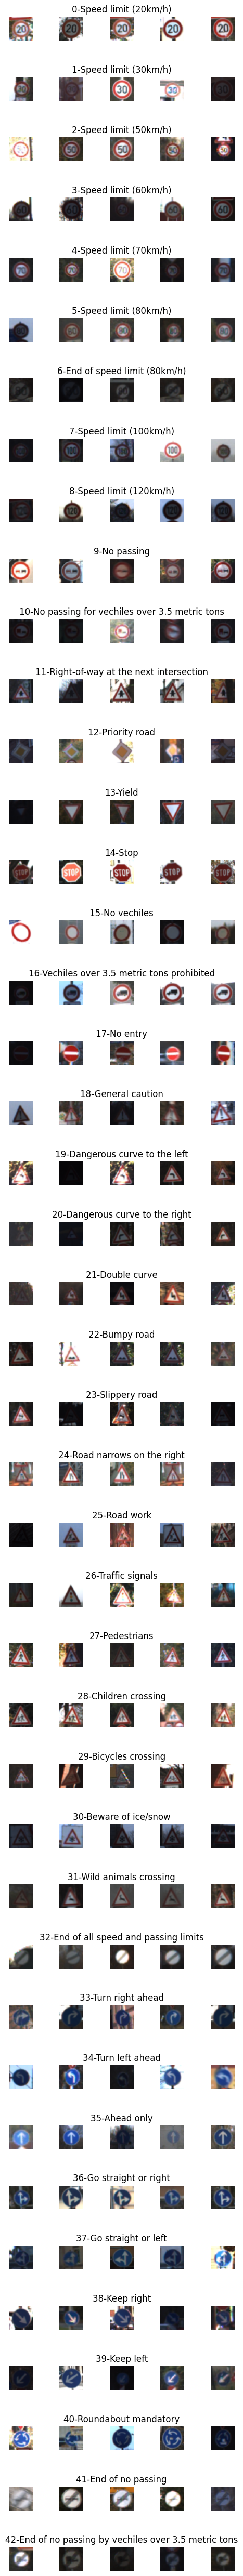

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_of_classes = 43
fig, axes = plt.subplots(nrows=num_of_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()
for col in range(cols):
  for i, row in data.iterrows():
    x_selected = X_train[y_train == i]
    axes[i][col].imshow(x_selected[random.randint(0, len(x_selected - 1))], cmap=plt.get_cmap("gray"))
    axes[i][col].axis("off")
    if col == 2:
      axes[i][col].set_title(str(i) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))

Text(0, 0.5, 'no. of images')

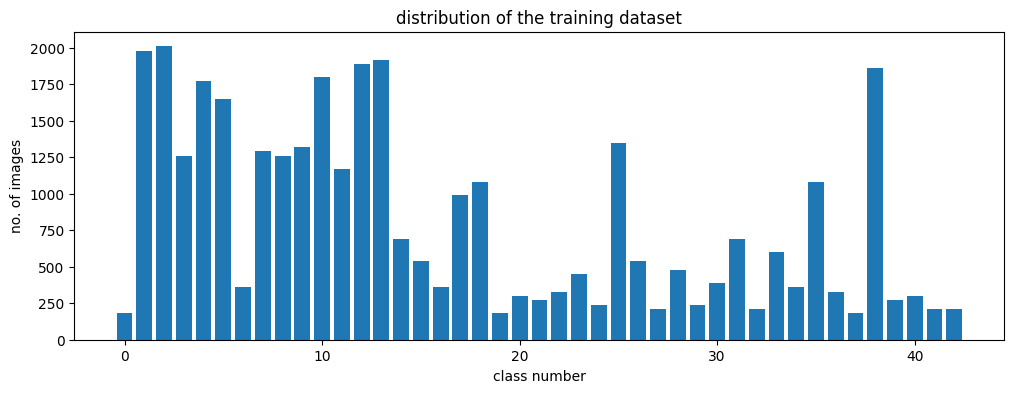

In [ ]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_of_classes), num_of_samples)
plt.title("distribution of the training dataset")
plt.xlabel("class number")
plt.ylabel("no. of images")

(32, 32, 3)
36


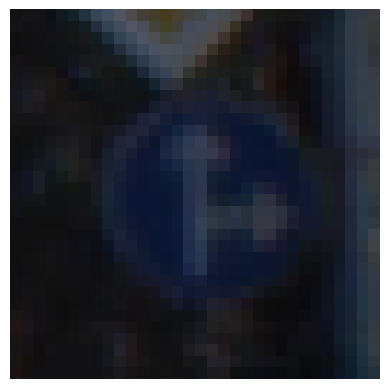

In [ ]:
import cv2
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

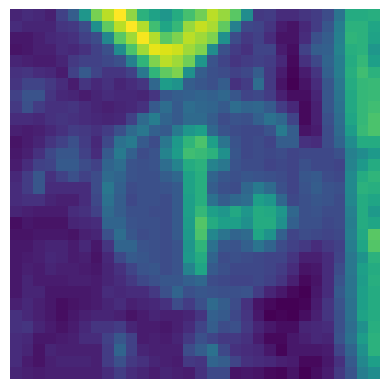

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

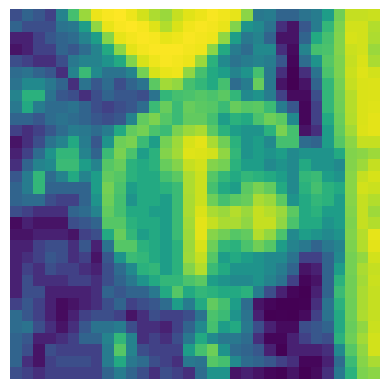

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid)))
X_test = np.array(list(map(preprocessing, X_test)))

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

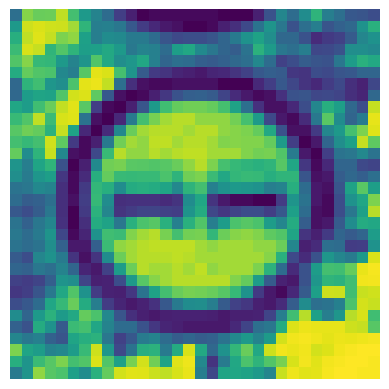

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)
datagen.fit(X_train)

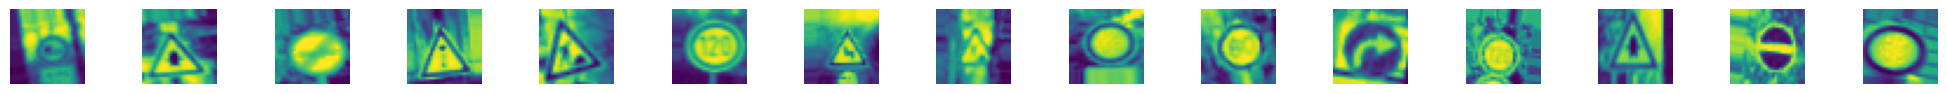

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)
fig, axes = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axes[i].imshow(X_batch[i].reshape(32, 32))
  axes[i].axis("off")

In [ ]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation="relu"))
  model.add(Conv2D(60, (5, 5), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(30, (3, 3), activation="relu"))
  model.add(Conv2D(30, (3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_of_classes, activation="softmax"))
  model.compile(Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
model = modified_model()
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
h = model.fit(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_valid, y_valid), shuffle=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 695/2000 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.2841 - loss: 2.6279

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4229 - loss: 2.0716 - val_accuracy: 0.8864 - val_loss: 0.3528
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8177 - loss: 0.5953 - val_accuracy: 0.9587 - val_loss: 0.1430
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8908 - loss: 0.3517 - val_accuracy: 0.9751 - val_loss: 0.0906
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9168 - loss: 0.2655 - val_accuracy: 0.9782 - val_loss: 0.0769
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9339 - loss: 0.2111 - val_accuracy: 0.9830 - val_loss: 0.0576
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9429 - loss: 0.1810 - val_accuracy: 0.9828 - val_loss: 0.0606
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9476 - loss: 0.1630 - val_accuracy: 0.9891 - val_loss: 0.0456
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9554 - loss: 0.1457 - val

Text(0.5, 0, 'epoch')

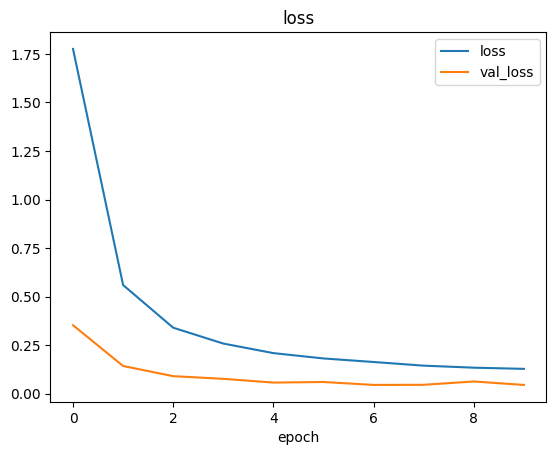

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

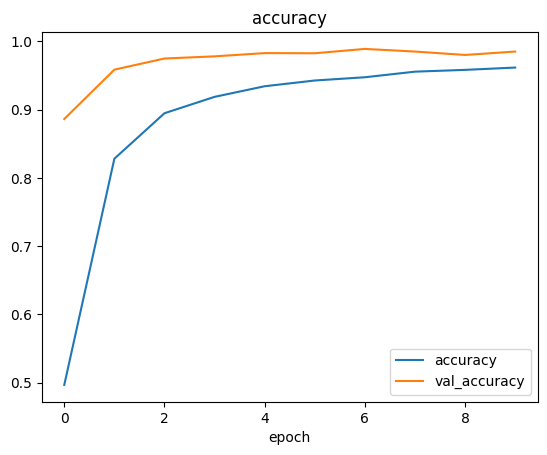

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('test score: ', score[0])
print('test accuracy: ', score[1])

test score:  0.16177888214588165
test accuracy:  0.9580364227294922


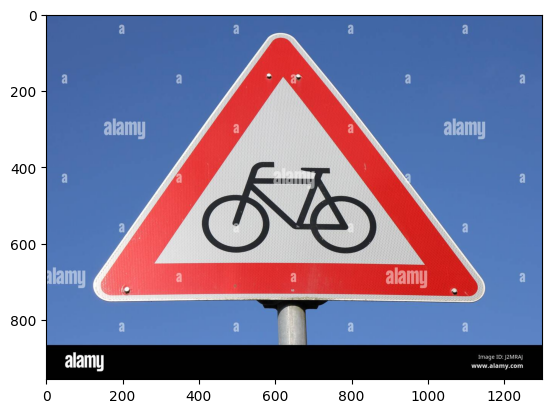

In [ ]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


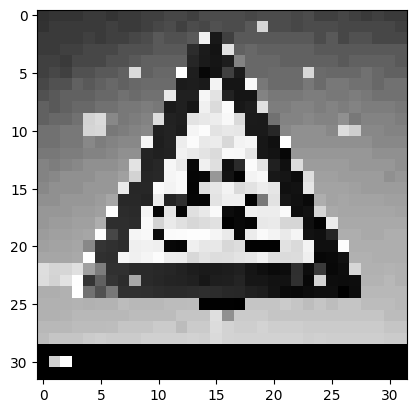

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
 img = img.reshape(1, 32, 32, 1)

In [ ]:
prediction = model.predict(img)
predicted_class_index = np.argmax(prediction)
print("predicted sign: " + str(predicted_class_index))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
predicted sign: 29
